In [1]:
from __future__ import print_function
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import h5py
import scipy
from PIL import Image
from scipy import ndimage

#coding=utf-8

%matplotlib inline


In [2]:
#data -- a 10000x3072 numpy array of uint8s. Each row(行) of the array stores a 32x32 colour image. 
#The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 3072 = 3 * (32 * 32) RGB*VH
#The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
#labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1') # 编码方式
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
    return X, Y
def load_CIFAR10(dir):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(dir, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    # load test dataset
    Xte, Yte = load_CIFAR_batch(os.path.join('datasets', dir, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


In [3]:
def distance(X_test, X_train):
    """
    输入:
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    输出:
    distances -- 测试数据与各个训练数据之间的距离,大小为(测试样本数, 训练样本数量)的numpy数组
    """
    num_test = X_test.shape[1]
    num_train = X_train.shape[1]
    distances = np.zeros((num_test, num_train))
    # (X_test - X_train)*(X_test - X_train) = -2X_test*X_train + X_test*X_test + X_train*X_train
    dist1 = np.multiply(np.dot(X_test.T, X_train), -2)    # -2X_test*X_train, shape (num_test, num_train)
    dist2 = np.sum(np.square(X_test.T), axis=1, keepdims=True)    # X_test*X_test, shape (num_test, 1)    元素方   1000*1
    dist3 = np.sum(np.square(X_train), axis=0,keepdims=True)    # X_train*X_train, shape(1, num_train)   1 * 50000   每张图内求和
    distances = np.sqrt(dist1 + dist2 + dist3)  # 不同维度的矩阵相加会扩展

    return distances


In [4]:
def predict(X_test, X_train, Y_train, k = 1):
    """ 
    输入:
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    Y_train -- 由numpy数组（向量）表示的训练标签，大小为 (1, 训练样本数)
    k -- 选取与训练集最近邻的数量
    输出:
    Y_prediction -- 包含X_test中所有预测值的numpy数组（向量）
    distances -- 由numpy数组表示的测试数据与各个训练数据之间的距离,大小为(测试样本数, 训练样本数)
    """
    distances = distance(X_test, X_train) # 1000 * 50000
    num_test = X_test.shape[1]            # 1000
    Y_prediction = np.zeros(num_test)
    for i in range(num_test):
        dists_min_k = np.argsort(distances[i])[:k]           # 按照距离递增次序进行排序,选取距离最小的k个点 
        y_labels_k = Y_train[0,dists_min_k]                  # 确定前k个点的所在类别
        Y_prediction[i] = np.argmax(np.bincount(y_labels_k)) # 返回前k个点中出现频率最高的类别作为测试数据的预测分类

    return Y_prediction, distances


In [5]:
def model(X_test, Y_test, X_train, Y_train, k = 1, print_correct = False):
    """
    输入：
    X_test -- 由numpy数组表示的测试集，大小为(图片长度 * 图片高度 * 3 , 测试样本数)
    X_train -- 由numpy数组表示的训练集，大小为(图片长度 * 图片高度 * 3 , 训练样本数)
    Y_train -- 由numpy数组（向量）表示的训练标签，大小为 (1, 训练样本数)
    Y_test -- 由numpy数组（向量）表示的测试标签，大小为 (1, 测试样本数)
    k -- 选取与训练集最近邻的数量
    print_correct -- 设置为true时，打印正确率
    输出：
    d -- 包含模型信息的字典
    """
    Y_prediction, distances = predict(X_test, X_train, Y_train, k)
    num_correct = np.sum(Y_prediction == Y_test)
    accuracy = np.mean(Y_prediction == Y_test) # mean 取均值
    if print_correct:
        print('Correct %d/%d: The test accuracy: %f' % (num_correct, X_test.shape[1], accuracy))
    d = {"k": k,
         "Y_prediction": Y_prediction, 
         "distances" : distances,
         "accuracy": accuracy}
    return d


In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'E:\Dian\Class\Junior_spring\ML\cifar-10-python\cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# 训练样本，训练标签，测试集，测试标签
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# list
classes = ['plane', 'car', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
num_each_class = 7

"""
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, num_each_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + (y + 1)
            plt.subplot(num_each_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
"""

"\n    for y, cls in enumerate(classes):\n        idxs = np.flatnonzero(y_train == y)\n        idxs = np.random.choice(idxs, num_each_class, replace=False)\n        for i, idx in enumerate(idxs):\n            plt_idx = i * num_classes + (y + 1)\n            plt.subplot(num_each_class, num_classes, plt_idx)\n            plt.imshow(X_train[idx].astype('uint8'))\n            plt.axis('off')\n            if i == 0:\n                plt.title(cls)\n    plt.show()\n"

In [7]:
size_train = 50000
size_test = 1000
X_train = np.reshape(X_train, (X_train.shape[0], -1)).T #( ,50000) T
X_test = np.reshape(X_test, (X_test.shape[0], -1)).T    #( ,10000) T
Y_set_train = y_train[:size_train].reshape(1,-1)   # (1, )
Y_set_test = y_test[:size_test].reshape(1,-1)   # (1, )


X_set_train = X_train[:,:size_train]
X_set_test = X_test[:,:size_test]

del X_train, y_train
del X_test, y_test

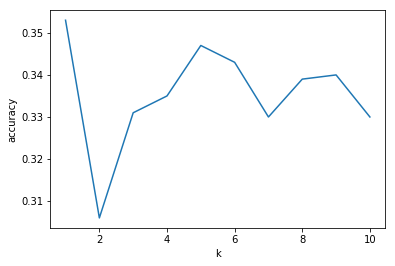

In [8]:
models = {}
k = []
accuracys = []
# 1~10
for i in range(1,11):
    models[str(i)] = model(X_set_test, Y_set_test, X_set_train, Y_set_train, i, print_correct = False)
    k.append(models[str(i)]["k"])
    accuracys.append(models[str(i)]["accuracy"])
plt.plot(k, accuracys)
plt.ylabel('accuracy')
plt.xlabel('k')
plt.show()



In [30]:
a = np.array([[1,2,3]])
b = a.reshape(3,1)


np.dot(b,a)


array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])